In [1]:
import os.path, logging
import numpy as np
import pandas as pd
from keras.layers import Input, Embedding, concatenate, dot
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import q
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
rating_path = 'dataset/rating.csv'
rating = pd.read_csv(rating_path)
rating.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [3]:
rating.userId = rating.userId.astype('category').cat.codes.values
rating.movieId = rating.movieId.astype('category').cat.codes.values
rating.head(3)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rating, test_size=0.2)
train.head(3)
y_true = test.rating

In [16]:
import keras
latent = 8
learning_rate=0.001
num_users, num_movies = len(rating.userId.unique()), len(rating.movieId.unique())

user_input = keras.layers.Input(shape=[1, ], name='User')
user_embedding = keras.layers.Embedding(num_users + 1, latent)(user_input)
user_vec = keras.layers.Flatten()(user_embedding)
user_vec = keras.layers.Dropout(0.15)(user_vec)

movie_input = keras.layers.Input(shape=[1, ], name='Item')
movie_embedding = keras.layers.Embedding(num_movies + 1, latent)(movie_input)
movie_vec = keras.layers.Flatten()(movie_embedding)
movie_vec = keras.layers.Dropout(0.15)(movie_vec)

concat = concatenate([movie_vec, user_vec], axis=-1, name='concat')

concat = keras.layers.Dropout(0.2)(concat)
output = keras.layers.Dense(300)(concat)
output = keras.layers.BatchNormalization()(output)

output = keras.layers.Dropout(0.2)(output)
output = keras.layers.Dense(100)(output)
output = keras.layers.Dense(50, activation='relu')(output)

#pred_mf = keras.layers.merge([movie_vec_mf, user_vec_mf], mode='dot',name='Dot')

pred = keras.layers.Dense(1, activation='relu', name='Activation')(output)

result = keras.layers.Dense(1, name='Prediction')(pred)

model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer='adam', loss='mean_squared_error')

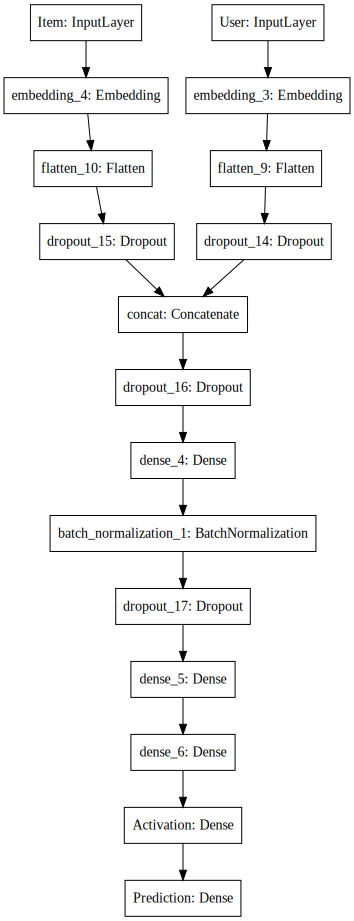

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


In [18]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=25, verbose=0, validation_split=0.1)


In [19]:
from sklearn.metrics import mean_squared_error
y_hat_2 = np.round(model.predict([test.userId, test.movieId]),0)
print(mean_squared_error(y_true, y_hat_2))

print(mean_squared_error(y_true, model.predict([test.userId, test.movieId])))

0.8402667592225307
0.7550344833958433


Text(0, 0.5, 'Train Error')

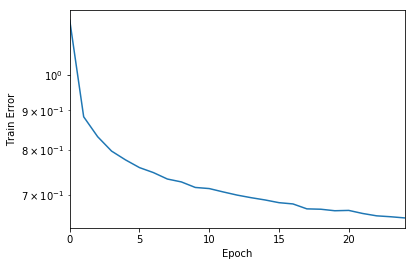

In [20]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")